# Error on the reconstructed covariance - possible way to predict solar flares?

In this notebook we want to test on multiple flare events if it's true that the reconstruction error on the covariance starts to fail before the flare is visible.

In [27]:
!pip install img2pdf --user

     |████████████████████████████████| 112kB 9.2MB/s eta 0:00:01
     |████████████████████████████████| 2.3MB 13.5MB/s eta 0:00:01
  Created wheel for img2pdf: filename=img2pdf-0.4.0-cp37-none-any.whl size=40502 sha256=459277d7f7db7bbebd1edb5e721dd5972a26ab26e58dbfe53d4ac667b5e5e181
  Stored in directory: /home/Valentina/.cache/pip/wheels/90/f5/7f/b88a76bac33669118e7549f4856bbe975a3ad2e59280c59196
Successfully built img2pdf
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from torch.utils.data import DataLoader
import torch

from scipy.ndimage import uniform_filter, convolve
from scipy.stats import levene

import moviepy.video.io.ImageSequenceClip

from sdo.datasets.sdo_dataset import SDO_Dataset
from sdo.datasets.virtual_telescope_sdo_dataset import VirtualTelescopeSDO_Dataset
from sdo.models.vt_models.vt_unet import VT_UnetGenerator
from sdo.metrics.covariance import time_covariance, cov_1d, neighbor_cov
from sdo.datasets.dates_selection import get_datetime

import sunpy.visualization.colormaps as cm

# Load the trained model for inference (it takes a couple of mins)

In [3]:
results_path = '/fdl_sdo_data/bucket/EXPERIMENT_RESULTS/VIRTUAL_TELESCOPE/vale_exp_20/'
model_path = results_path + '0600_vale_exp_20_model.pth'
model = VT_UnetGenerator(input_shape=[3, 512, 512])
state_dict = torch.load(model_path)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "") 
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.eval();

# Identify some events for the experiments

In [4]:
flares_path = '/home/Valentina//expanding-sdo-capabilities/rare_events/flares_modelling.csv'

In [5]:
flares_df = pd.read_csv(flares_path)
flares_df

,event_type,event_coordsys,hpc_x,hpc_y,hgc_x,hgc_y,start_time,end_time,frm_name,obs_observatory,obs_instrument,kb_archivid,HER event summary
0,FL,UTC-HGS-TOPO,16.00068,-223.2180,34.493617,-20,2011-02-14T04:29:00,2011-02-14T05:09:00,SWPC,GOES,GOES,ivo://helio-informatics.org/FL_SECstandard_201...,https://www.lmsal.com/hek/her?cmd=view-voevent...
1,FL,UTC-HGS-TOPO,-470.18040,486.3882,165.035490,24,2011-03-01T02:30:00,2011-03-01T04:40:00,SWPC,GOES,GOES,ivo://helio-informatics.org/FL_SECstandard_201...,https://www.lmsal.com/hek/her?cmd=view-voevent...
2,FL,UTC-HGS-TOPO,0.00000,-66.6528,-80.512570,0,2010-11-05T12:43:00,2010-11-05T14:06:00,SWPC,GOES,GOES,ivo://helio-informatics.org/FL_SECstandard_201...,https://www.lmsal.com/hek/her?cmd=view-voevent...
3,FL,UTC-HGS-TOPO,328.35900,-229.1394,33.086730,-20,2011-02-15T19:30:00,2011-02-15T20:53:00,SWPC,GOES,GOES,ivo://helio-informatics.org/FL_SECstandard_201...,https://www.lmsal.com/hek/her?cmd=view-voevent...
4,FL,UTC-HGS-TOPO,0.00000,-90.0402,28.028327,0,2011-07-28T02:19:00,2011-07-28T02:29:00,SWPC,GOES,GOES,ivo://helio-informatics.org/FL_SECstandard_201...,https://www.lmsal.com/hek/her?cmd=view-voevent...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,FL,UTC-HGS-TOPO,-777.47400,-347.2902,-153.199290,-19,2010-11-06T15:27:00,2010-11-06T15:44:00,SWPC,GOES,GOES,ivo://helio-informatics.org/FL_SECstandard_201...,https://www.lmsal.com/hek/her?cmd=view-voevent...
80,FL,UTC-HGS-TOPO,0.00000,97.0440,-100.616140,0,2011-01-28T00:44:00,2011-01-28T01:10:00,SWPC,GOES,GOES,ivo://helio-informatics.org/FL_SECstandard_201...,https://www.lmsal.com/hek/her?cmd=view-voevent...
81,FL,UTC-HGS-TOPO,168.14460,862.2900,44.443398,56,2011-02-14T17:20:00,2011-02-14T17:32:00,SWPC,GOES,GOES,ivo://helio-informatics.org/FL_SECstandard_201...,https://www.lmsal.com/hek/her?cmd=view-voevent...
82,FL,UTC-HGS-TOPO,0.00000,122.3886,91.988507,0,2011-03-09T01:52:00,2011-03-09T02:07:00,SWPC,GOES,GOES,ivo://helio-informatics.org/FL_SECstandard_201...,https://www.lmsal.com/hek/her?cmd=view-voevent...


In [6]:
# we select 3 episodes at different times and of different length
df_selection = flares_df.loc[[1, 6, 77]][['start_time', 'end_time']]
df_selection

,start_time,end_time
1,2011-03-01T02:30:00,2011-03-01T04:40:00
6,2011-06-16T10:13:00,2011-06-16T10:29:00
77,2011-04-22T16:56:00,2011-04-22T17:14:00


In [7]:
# convert in datetimes and add the buffer
df_selection['start_datetime'] =  df_selection['start_time'].apply(lambda x: get_datetime(x, 1, 30, add=False))
df_selection['end_datetime'] =  df_selection['end_time'].apply(lambda x: get_datetime(x, 1, 30, add=True))
df_selection

,start_time,end_time,start_datetime,end_datetime
1,2011-03-01T02:30:00,2011-03-01T04:40:00,2011-03-01 01:00:00,2011-03-01 06:10:00
6,2011-06-16T10:13:00,2011-06-16T10:29:00,2011-06-16 08:43:00,2011-06-16 11:59:00
77,2011-04-22T16:56:00,2011-04-22T17:14:00,2011-04-22 15:26:00,2011-04-22 18:44:00


In [8]:
str(df_selection.loc[1].start_datetime)

'2011-03-01 01:00:00'

# Load the data

In [9]:
event = 77
folder = '/home/Valentina/results/exp_flares/' + f'flare_{event}/'
datetime_range = [[str(df_selection.loc[event].start_datetime), str(df_selection.loc[event].end_datetime)]]
data = VirtualTelescopeSDO_Dataset(data_basedir='/fdl_sdo_data/SDOMLmm/fdl_sw/SDOMLmm', 
    data_inventory='/home/Valentina/inventory_1904.pkl', 
    instr=["AIA", "AIA", "AIA", "AIA"], 
    num_channels = 4,
    channels=["0094", "0193", "0171", "0211"],
    datetime_range = datetime_range,
    resolution=512,
    subsample=1,
    test=False,
    test_ratio=0.0,
    shuffle=False,
    normalization=0,
    scaling=True,
    apodize=False,
    holdout=False)

/home/Valentina/expanding-sdo-capabilities/src/sdo/datasets/dates_selection.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_df['date'] = sel_df.apply(from_row_to_date, axis=1)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [10]:
# in the first event we have 43 timestamps, at a distance of 6 minutes, given the inference is a bit slow 
# we might need to reduce the frequency
len(data.timestamps)

34

In [11]:
data.timestamps

[(2011, 4, 22, 15, 24),
 (2011, 4, 22, 15, 30),
 (2011, 4, 22, 15, 36),
 (2011, 4, 22, 15, 42),
 (2011, 4, 22, 15, 48),
 (2011, 4, 22, 15, 54),
 (2011, 4, 22, 16, 0),
 (2011, 4, 22, 16, 6),
 (2011, 4, 22, 16, 12),
 (2011, 4, 22, 16, 18),
 (2011, 4, 22, 16, 24),
 (2011, 4, 22, 16, 30),
 (2011, 4, 22, 16, 36),
 (2011, 4, 22, 16, 42),
 (2011, 4, 22, 16, 48),
 (2011, 4, 22, 16, 54),
 (2011, 4, 22, 17, 0),
 (2011, 4, 22, 17, 6),
 (2011, 4, 22, 17, 12),
 (2011, 4, 22, 17, 18),
 (2011, 4, 22, 17, 24),
 (2011, 4, 22, 17, 30),
 (2011, 4, 22, 17, 36),
 (2011, 4, 22, 17, 42),
 (2011, 4, 22, 17, 48),
 (2011, 4, 22, 17, 54),
 (2011, 4, 22, 18, 0),
 (2011, 4, 22, 18, 6),
 (2011, 4, 22, 18, 12),
 (2011, 4, 22, 18, 18),
 (2011, 4, 22, 18, 24),
 (2011, 4, 22, 18, 30),
 (2011, 4, 22, 18, 36),
 (2011, 4, 22, 18, 42)]

# Run the inference for each timestamp

In [12]:
# we collect the data for the analysis
input_data = []
gt_img = []
timestamps = []
for idx, _ in enumerate(data.timestamps):
    input_data.append(data[idx][0])
    gt_img.append(data[idx][1])
    timestamps.append(data[idx][2])

In [13]:
# compute the virtual image for each timestamp (this will take several minutes)
outputs = []
filename = '/home/Valentina/results/exp_flares/' + f'flares_{event}_outputs.rt'
if os.path.isfile(filename):
    outputs = torch.load(filename)
    if len(outputs)!=len(data.timestamps):
        print("Error, lenght of the saved files doesn't match")
else:
    for idx, _ in enumerate(data.timestamps):
        print(data[idx][2])
        outputs.append(
            model(data[idx][0].unsqueeze(0)).detach().numpy().reshape(1, 512, 512)
        )
    filename = '/home/Valentina/results/exp_flares/' + f'flares_{event}_outputs.rt'
    torch.save(outputs, filename)

# Looking at difference in covariance at interval of 6mins

In [14]:
results_cov = pd.DataFrame()
results = pd.DataFrame()
orig_channel = '211'
for i, _ in enumerate(data.timestamps):
    ts = '-'.join([str(i.item()) for i in timestamps[i]])
    X_s = outputs[i].reshape(512, 512)
    X_orig = gt_img[i].detach().numpy().reshape(512, 512)
    for j, ch in enumerate(["094", "193", "171"]):
        cov_orig, cov_synth = 0, 0
        Y = input_data[i][j].detach().numpy().reshape(512, 512)
        cov_orig = cov_1d(X_orig,Y)
        cov_synth = cov_1d(X_s,Y)
        flux = input_data[i][j].detach().numpy().sum()
        flux_orig = X_orig.sum()
        diff_orig = (X_s - X_orig).sum()
        percent_diff_orig = (X_s - X_orig).sum()*100/X_orig.sum()
        results_cov = results_cov.append(
            pd.DataFrame(index=[i], data={'Timestamp': ts, 'Channel': ch, 
                                'Flux': flux,
                               'True Cov': cov_orig, 'Pred Cov': cov_synth, 
                               'Diff': (cov_orig - cov_synth), 
                               '%Diff': (cov_orig - cov_synth)*100/cov_orig})
        )
    results = results.append(pd.DataFrame(index=[i], data={'Timestamp': ts, 'Channel': orig_channel,
                                                               'Flux': flux_orig, 
                                                               'Diff': diff_orig,
                                                               '%Diff': percent_diff_orig}
                                             ))

In [15]:
results_cov.reset_index().drop('index', axis=1).style.background_gradient(cmap='YlOrRd')

,Timestamp,Channel,Flux,True Cov,Pred Cov,Diff,%Diff
0,2011-4-22-15-24,094,95159.5,0.323128,0.322587,0.000540825,0.167372
1,2011-4-22-15-24,193,45243.4,0.0744994,0.0754577,-0.000958394,-1.28645
2,2011-4-22-15-24,171,86929.4,0.207338,0.210728,-0.00338982,-1.63492
3,2011-4-22-15-30,094,95806.3,0.309965,0.311836,-0.00187129,-0.603712
4,2011-4-22-15-30,193,45249.8,0.073358,0.0743419,-0.000983913,-1.34125
5,2011-4-22-15-30,171,86823.6,0.203912,0.207147,-0.00323504,-1.58649
6,2011-4-22-15-36,094,96246.4,0.297184,0.29794,-0.000756207,-0.254457
7,2011-4-22-15-36,193,45212.2,0.0719649,0.0727717,-0.000806841,-1.12116
8,2011-4-22-15-36,171,86747.4,0.200959,0.203628,-0.00266988,-1.32857
9,2011-4-22-15-42,094,96384.7,0.305148,0.304973,0.000174761,0.0572711


* As expected results are very different for 193/171 and 094, being in general much worse for 094
* Difference between real and predicted covariance >1h before the flare is 4%, but can arrive up to 20% in 094
* After and close to the flare the predicted covariance is completely off and systematically larger

In [16]:
results.style.background_gradient(cmap='YlOrRd')

,Timestamp,Channel,Flux,Diff,%Diff
0,2011-4-22-15-24,211,58630.6,1263.8,2.15553
1,2011-4-22-15-30,211,58550.3,1466.02,2.50387
2,2011-4-22-15-36,211,58504.3,1522.58,2.60251
3,2011-4-22-15-42,211,58566.5,1312.23,2.24057
4,2011-4-22-15-48,211,58567.8,1414.53,2.41521
5,2011-4-22-15-54,211,59132.4,3115.06,5.26794
6,2011-4-22-16-0,211,59184.1,2831.85,4.78482
7,2011-4-22-16-6,211,59096,2913.04,4.92933
8,2011-4-22-16-12,211,59111.4,2706.02,4.57784
9,2011-4-22-16-18,211,59028.3,2552.81,4.32472


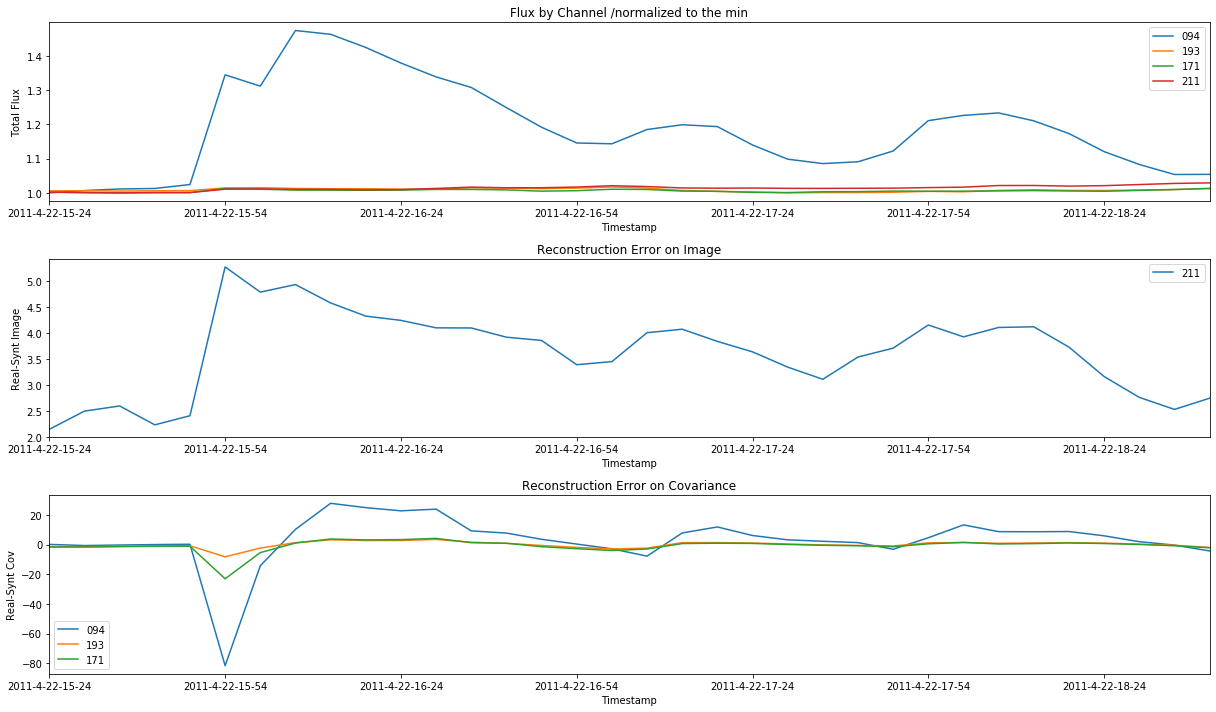

In [24]:
fig, axs = plt.subplots(3, 1)
for channel in ["094", "193", "171"]:
    tmp_results = results_cov[results_cov.Channel == channel]
    factor = tmp_results.Flux.min()
    tmp_results.Flux = tmp_results.Flux/factor
    tmp_results.plot(x='Timestamp', y='Flux', label=channel, figsize=(17, 10), ax=axs[0])
factor = results.Flux.min()
results.Flux = results.Flux/factor
results.plot(x='Timestamp', y='Flux', label='211', figsize=(17, 10), ax=axs[0])
axs[0].set_ylabel('Total Flux')
axs[0].set_title('Flux by Channel /normalized to the min')

results.plot(x='Timestamp', y= '%Diff', label='211', figsize=(17, 10), ax=axs[1])
axs[1].set_ylabel('Real-Synt Image')
axs[1].set_title('Reconstruction Error on Image')

for channel in ["094", "193", "171"]:
    results_cov[results_cov.Channel == channel].plot(x='Timestamp', y= '%Diff', label=channel, 
                                                     figsize=(17, 10), ax=axs[2])
axs[2].set_ylabel('Real-Synt Cov')
axs[2].set_title('Reconstruction Error on Covariance')
fig.tight_layout()
filename = folder + 'Errors_vs_timestamps.png'
plt.savefig(filename, bbox_inches='tight')

# Comparing maps using a Neighborhood covariance with rolling average window

tensor([2011,    4,   22,   15,   24])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


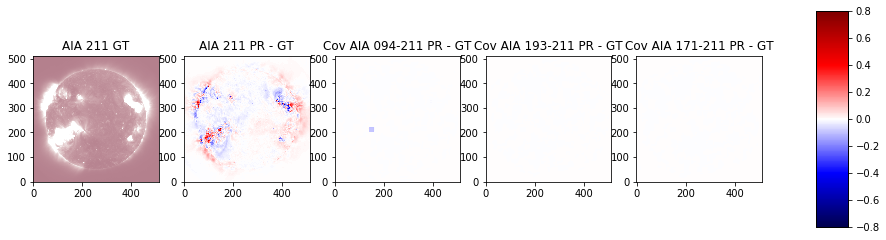

tensor([2011,    4,   22,   15,   30])


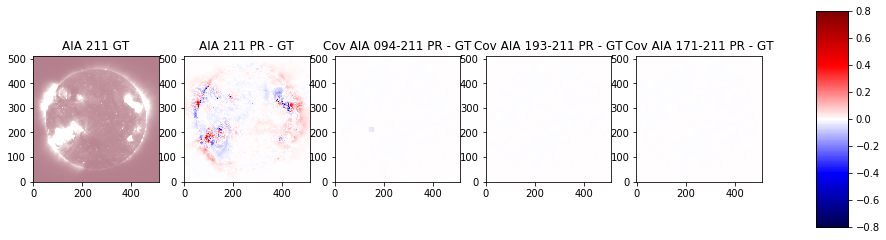

tensor([2011,    4,   22,   15,   36])


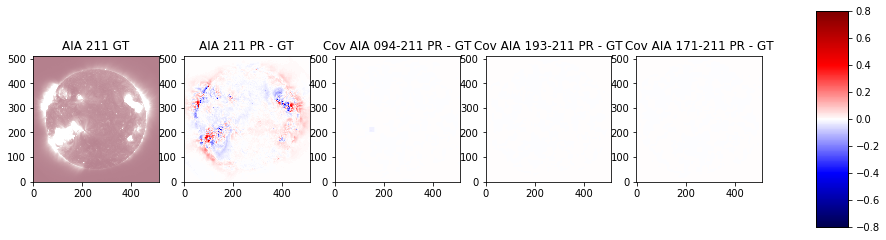

tensor([2011,    4,   22,   15,   42])


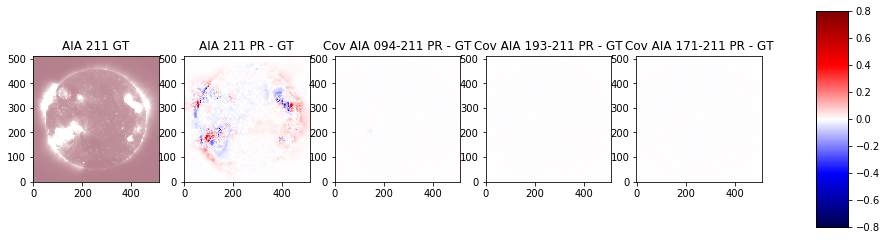

tensor([2011,    4,   22,   15,   48])


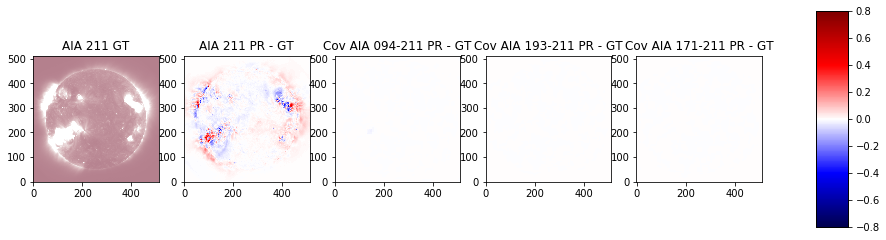

tensor([2011,    4,   22,   15,   54])


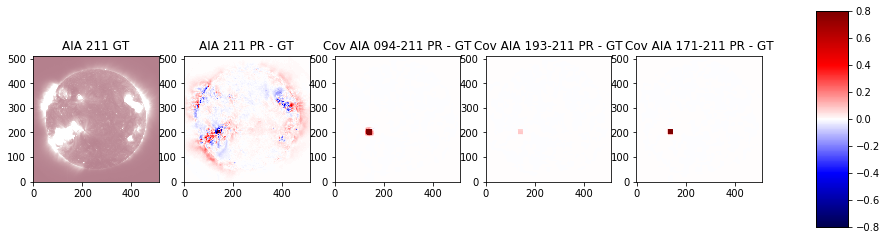

tensor([2011,    4,   22,   16,    0])


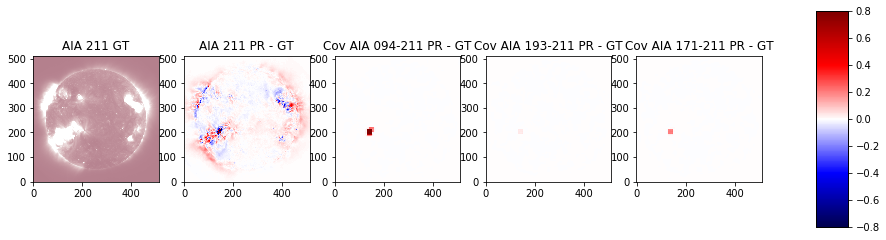

tensor([2011,    4,   22,   16,    6])


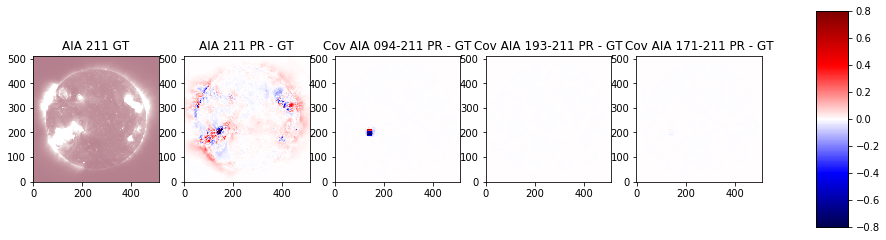

tensor([2011,    4,   22,   16,   12])


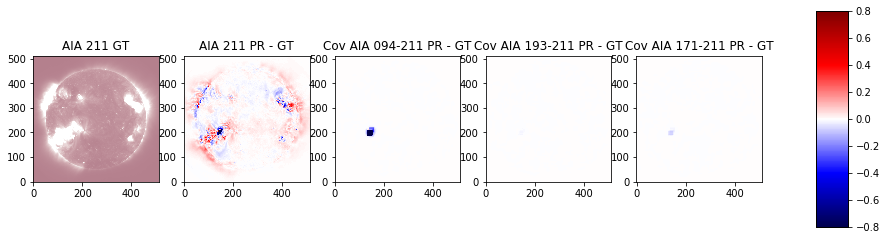

tensor([2011,    4,   22,   16,   18])


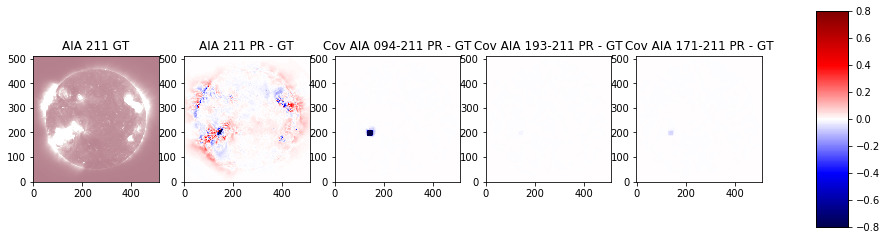

tensor([2011,    4,   22,   16,   24])


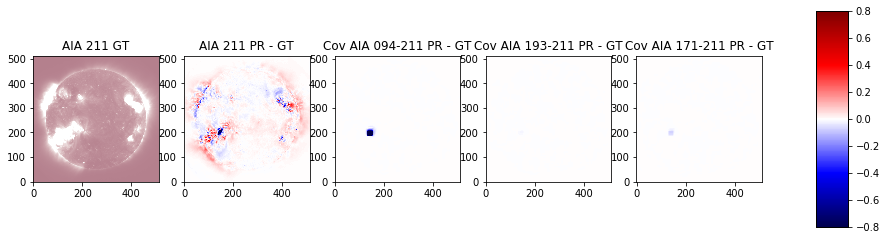

tensor([2011,    4,   22,   16,   30])


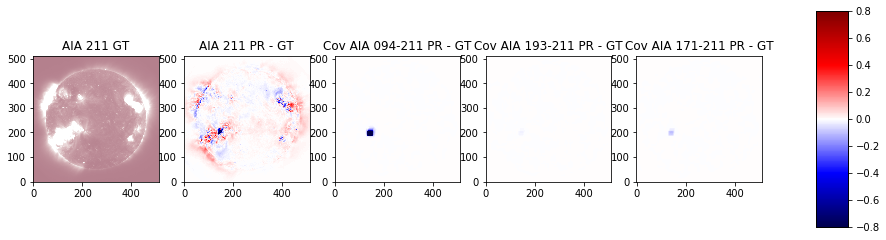

tensor([2011,    4,   22,   16,   36])


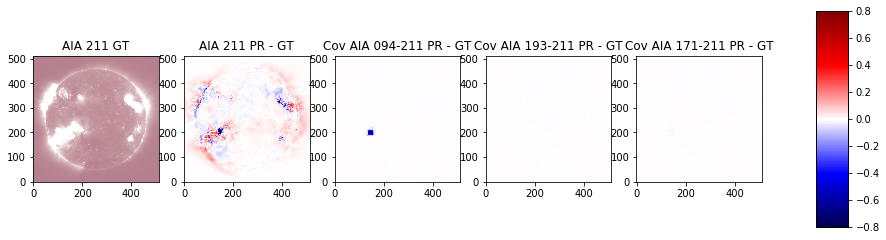

tensor([2011,    4,   22,   16,   42])


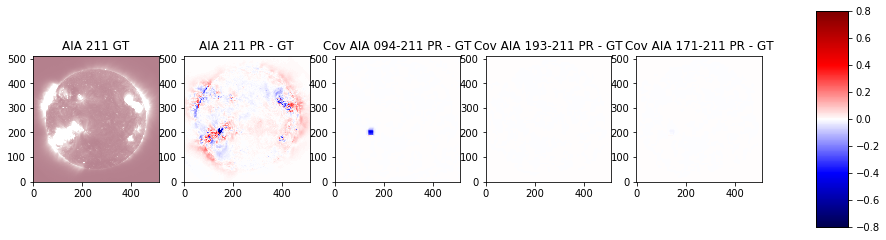

tensor([2011,    4,   22,   16,   48])


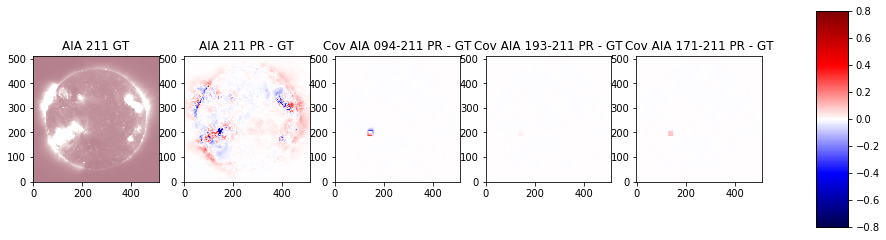

tensor([2011,    4,   22,   16,   54])


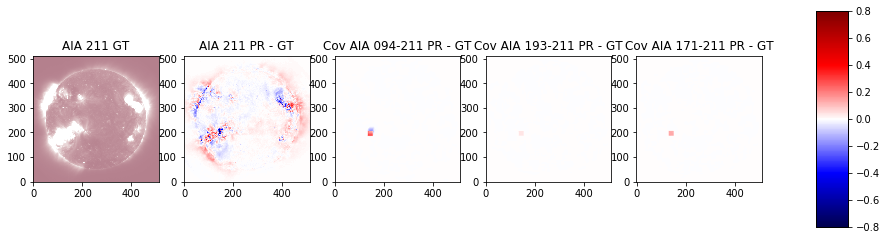

tensor([2011,    4,   22,   17,    0])


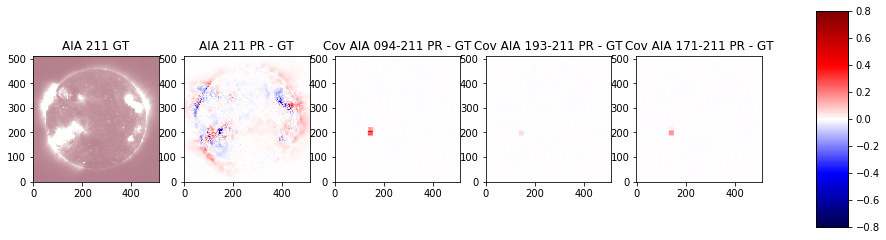

tensor([2011,    4,   22,   17,    6])


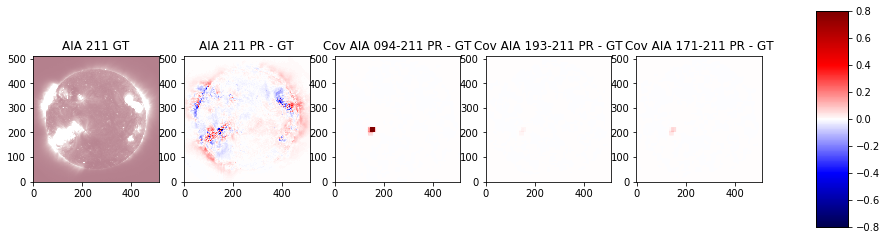

tensor([2011,    4,   22,   17,   12])


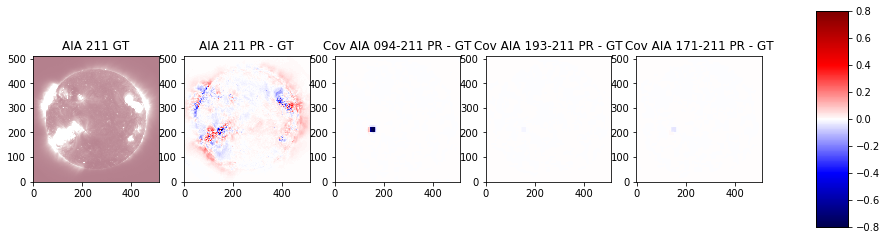

tensor([2011,    4,   22,   17,   18])


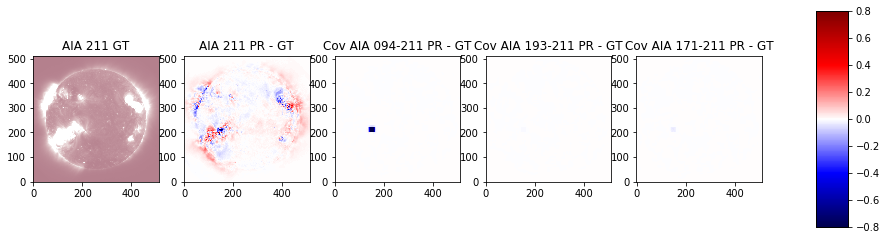

tensor([2011,    4,   22,   17,   24])


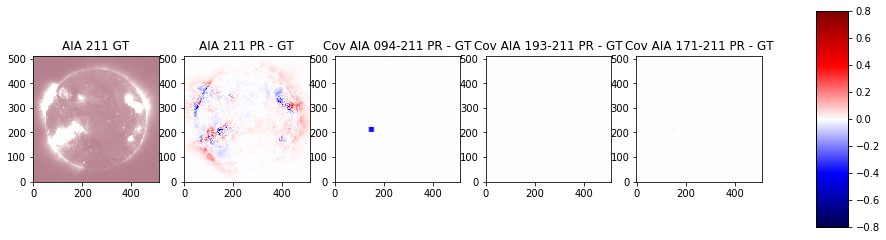

tensor([2011,    4,   22,   17,   30])


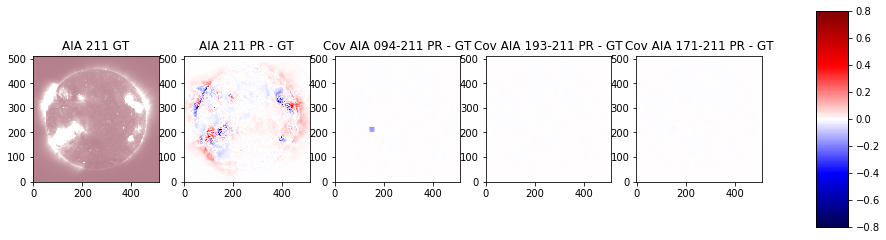

tensor([2011,    4,   22,   17,   36])


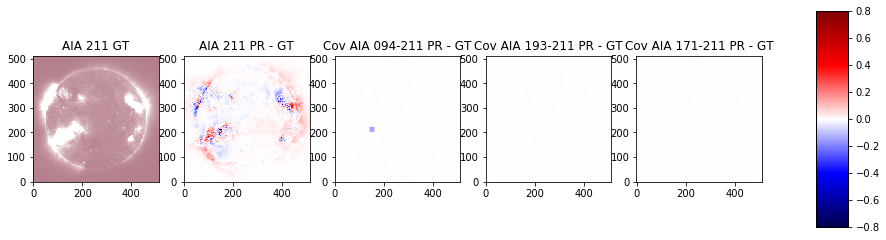

tensor([2011,    4,   22,   17,   42])


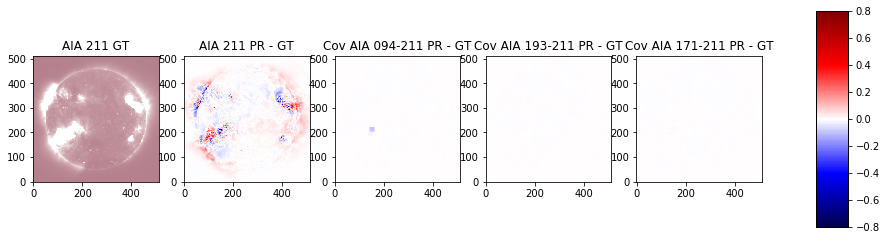

tensor([2011,    4,   22,   17,   48])


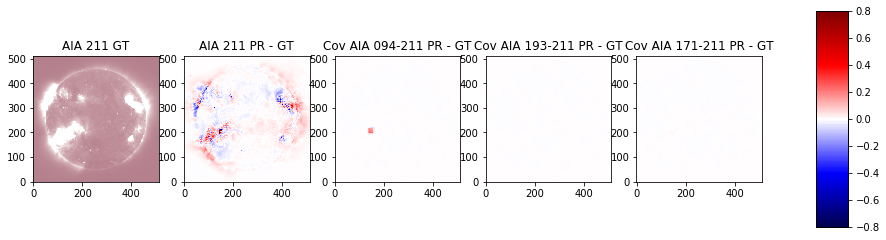

tensor([2011,    4,   22,   17,   54])


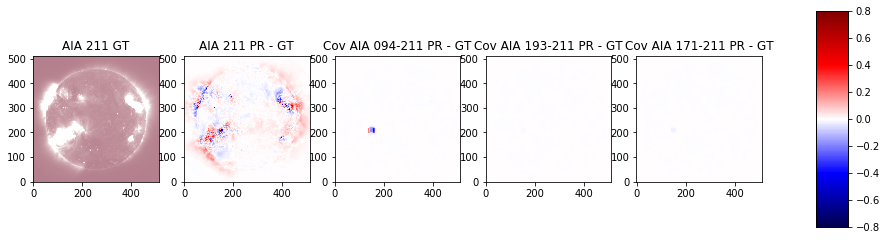

tensor([2011,    4,   22,   18,    0])


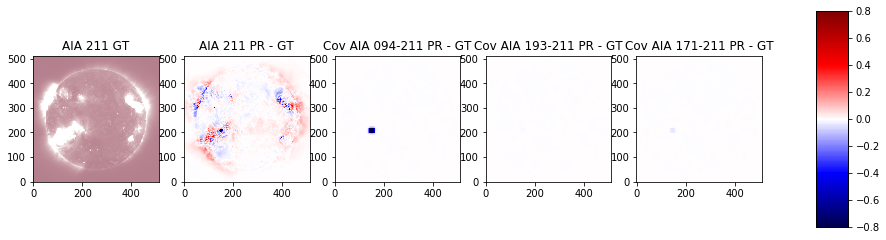

tensor([2011,    4,   22,   18,    6])


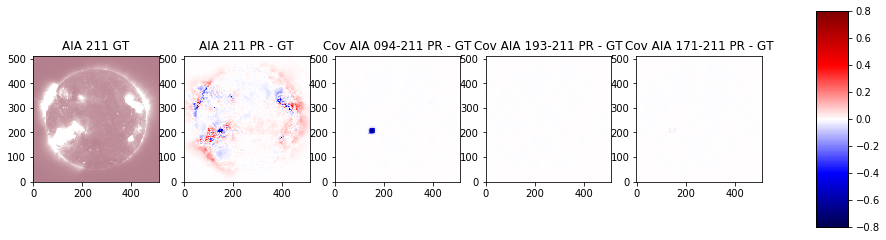

tensor([2011,    4,   22,   18,   12])


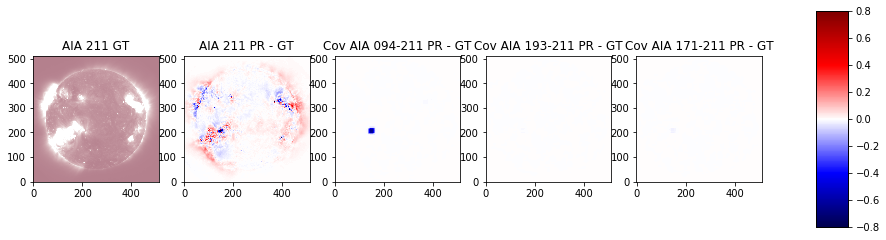

tensor([2011,    4,   22,   18,   18])


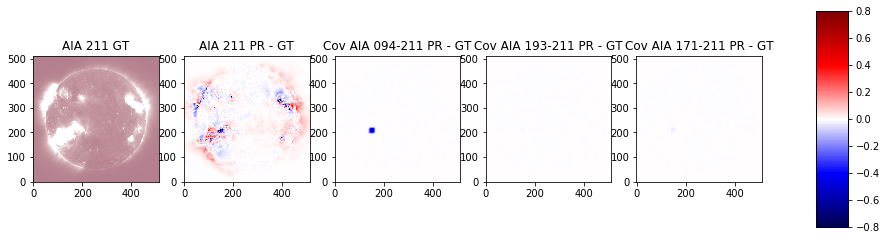

tensor([2011,    4,   22,   18,   24])


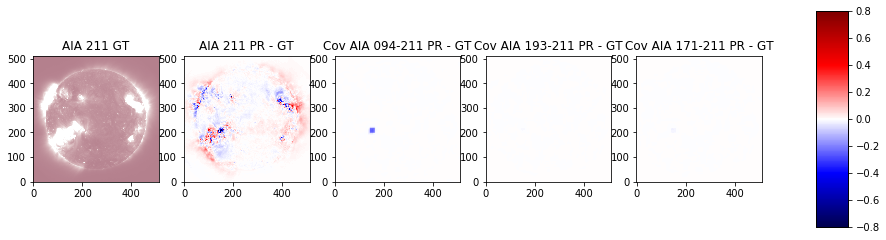

tensor([2011,    4,   22,   18,   30])


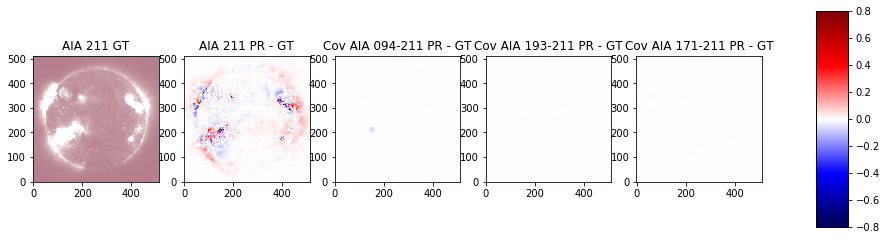

tensor([2011,    4,   22,   18,   36])


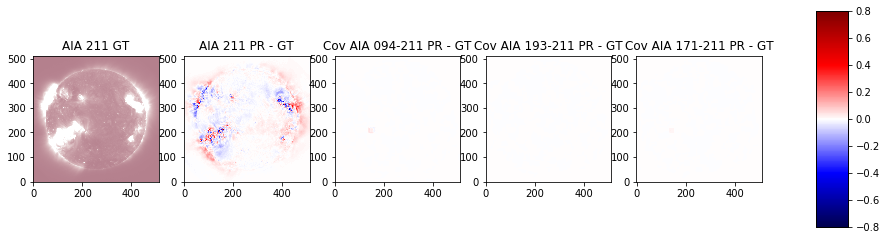

tensor([2011,    4,   22,   18,   42])


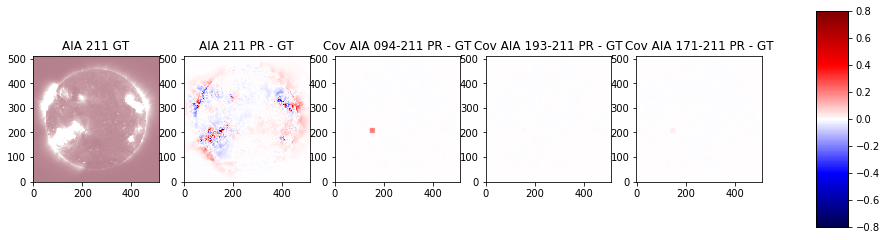

In [18]:
# compute covariance with real and synthetic image
for i, _ in enumerate(data.timestamps):
    fig, axs = plt.subplots(1,5, figsize=(15, 10))
    print(timestamps[i])
    X_s = outputs[i].reshape(512, 512)
    X_orig = gt_img[i].detach().numpy().reshape(512, 512)
    im = axs[0].set_title(f'AIA 211 GT')
    cmap=plt.get_cmap('sdoaia211')
    im = axs[0].imshow(X_orig, origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
    im = axs[1].set_title(f'AIA 211 PR - GT')
    im = axs[1].imshow((X_s - X_orig), cmap='seismic', origin='lower', vmin=-0.8, vmax=0.8)
    for j, ch in enumerate(["094", "193", "171"]):    
        Y = input_data[i][j].detach().numpy().reshape(512,512)
        cov_synth = neighbor_cov(X_s, Y, size=20)
        cov_orig = neighbor_cov(X_orig, Y, size=20)
        im = axs[j+2].set_title(f'Cov AIA {ch}-{211} PR - GT')
        im = axs[j+2].imshow((cov_synth - cov_orig), cmap='seismic', origin='lower', vmin=-0.8, vmax=0.8)
        fig.subplots_adjust(bottom=0.1, right=0.8, top=0.8)
        cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.3])
        fig.colorbar(im, cax=cbar_ax)
    plt.show()

as suggested by the aggregated covariance on the full image, results before and after the flare are much worse, 
particulalry the 094-211 pair. We can however see the error is localised

# Create video

In [19]:
# compute covariance with real and synthetic image
video_folder = folder + 'video/'
if not os.path.exists(video_folder):
    os.makedirs(video_folder)
fig_format = '.png'
cmap=plt.get_cmap('sdoaia211')

for i, timestamp in enumerate(data.timestamps):
    fig, axs = plt.subplots(1,2, figsize=(15, 10))
    filename = video_folder + '_'.join([str(number) for number in timestamp]) + fig_format
    X_s = outputs[i].reshape(512, 512)
    X_orig = gt_img[i].detach().numpy().reshape(512, 512)
    im = axs[0].set_title(f'{timestamp} AIA 211 GT')
    im = axs[0].imshow(X_orig, origin='lower', cmap=cmap)
    #im = axs[1].set_title(f'AIA 211 PR - GT')
    #im = axs[1].imshow((X_s - X_orig), cmap='seismic', origin='lower', vmin=-0.8, vmax=0.8)
    for j, ch in enumerate(["094"]):    
        Y = input_data[i][j].detach().numpy().reshape(512,512)
        cov_synth = neighbor_cov(X_s, Y, size=10)
        cov_orig = neighbor_cov(X_orig, Y, size=10)
        im = axs[j+1].set_title(f'Cov AIA {ch}-{211} PR - GT')
        im = axs[j+1].imshow((cov_synth - cov_orig), cmap='seismic', origin='lower', vmin=-0.8, vmax=0.8)
        fig.subplots_adjust(bottom=0.1, right=0.8, top=0.8)
        cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.3])
        fig.colorbar(im, cax=cbar_ax)
    # plt.show()
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

In [20]:
video_name = folder + f'flare_{event}.mp4'
image_files = [folder+'/'+ img for img in os.listdir(folder) if img.endswith(".png")]
image_files.sort()
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=2)
clip.write_videofile(video_name)

t:  24%|██▎       | 8/34 [00:00<00:00, 68.86it/s, now=None]

Moviepy - Building video /home/Valentina/results/exp_flares/flare_77/flare_77.mp4.
Moviepy - Writing video /home/Valentina/results/exp_flares/flare_77/flare_77.mp4



Moviepy - Done !
Moviepy - video ready /home/Valentina/results/exp_flares/flare_77/flare_77.mp4


In [21]:
from IPython.display import Video
Video(video_name)